In [12]:
import pandas as pd
import os
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math
from sklearn.metrics import calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



In [2]:
# Метрики расстояний
def euclidean_distance(p1, p2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))
def euclidean_distance2(p1, p2):
    return sum((a - b) ** 2 for a, b in zip(p1, p2))
def manhattan_distance(p1, p2):
    return sum(abs(a - b) for a, b in zip(p1, p2))
def chebyshev_distance(p1, p2):
    return max(abs(a - b) for a, b in zip(p1, p2))
def minkowski_distance(p1, p2, p, r):
    return sum(abs(a - b) ** p for a, b in zip(p1, p2)) ** (1 / r)
def mahalanobis_distance(p1, p2, cov_inv):
    delta = np.array(p1) - np.array(p2)
    return np.sqrt(np.dot(np.dot(delta.T, cov_inv), delta))
def spearman_rank_correlation(x, y):
    n = len(x)
    rank_x = {val: rank for rank, val in enumerate(sorted(x), 1)}
    rank_y = {val: rank for rank, val in enumerate(sorted(y), 1)}
    d_squared = sum((rank_x[a] - rank_y[b]) ** 2 for a, b in zip(x, y))
    return 1 - (6 * d_squared) / (n * (n**2 - 1))
def kendall_tau(x, y):
    n = len(x)
    concordant = discordant = 0
    for i in range(n):
        for j in range(i + 1, n):
            a = x[i] - x[j]
            b = y[i] - y[j]
            if a * b > 0:
                concordant += 1
            elif a * b < 0:
                discordant += 1
    return (concordant - discordant) / (0.5 * n * (n - 1))
def pearson_correlation(x, y):
    n = len(x)
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    num = sum((a - mean_x) * (b - mean_y) for a, b in zip(x, y))
    den_x = sum((a - mean_x) ** 2 for a in x)
    den_y = sum((b - mean_y) ** 2 for b in y)
    return num / math.sqrt(den_x * den_y)


2. Загрузка и первичная обработка данных

In [3]:
data = pd.read_excel('dataset.xlsx')
print("Типы данных в датасете:")
print(data.dtypes)

Типы данных в датасете:
Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object


3. Этап 1 — Преобразование категориальных данных

In [4]:
data['Extracurricular Activities'] = data['Extracurricular Activities'].map({'Yes': 1, 'No': 0})
print(data.head())

   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0              7               99                           1            9   
1              4               82                           0            4   
2              8               51                           1            7   
3              5               52                           1            5   
4              7               75                           0            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  


5. Этап 3 — Удаление выбросов по z-оценке

In [5]:
z_scores = np.abs(stats.zscore(data.select_dtypes(include=[np.number])))
data = data[(z_scores < 3).all(axis=1)]
print(f"Размер данных после удаления выбросов: {data.shape}")

Размер данных после удаления выбросов: (10000, 6)


6. Этап 4 — Нормализация MinMaxScaler

In [6]:
num_cols = data.select_dtypes(include=['float64', 'int64']).columns.difference(['Extracurricular Activities'])
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])
print(data.head())

   Hours Studied  Previous Scores  Extracurricular Activities  Sleep Hours  \
0          0.750         1.000000                           1          1.0   
1          0.375         0.711864                           0          0.0   
2          0.875         0.186441                           1          0.6   
3          0.500         0.203390                           1          0.2   
4          0.750         0.593220                           0          0.8   

   Sample Question Papers Practiced  Performance Index  
0                          0.111111           0.900000  
1                          0.222222           0.611111  
2                          0.222222           0.388889  
3                          0.222222           0.288889  
4                          0.555556           0.622222  


Вычисляем и визуализируем матрицу корреляции

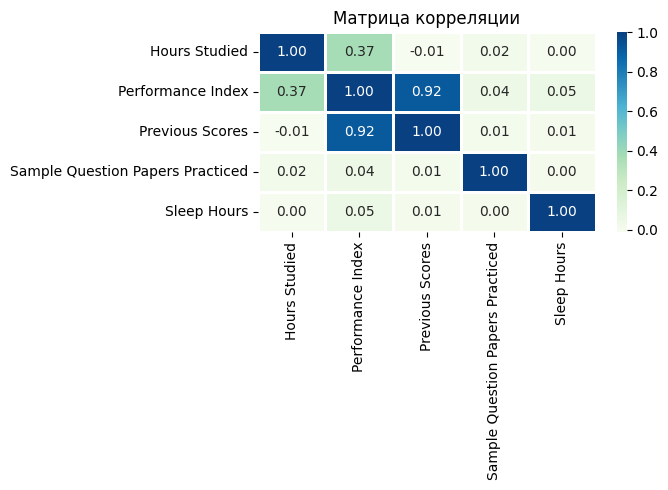

In [7]:
correlation_matrix = data[num_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=1, cmap='GnBu')
plt.title('Матрица корреляции')
plt.tight_layout()
plt.show()

7. Этап 5 — Подвыборка и матрица расстояний

In [8]:
def compute_distance_matrix(data, metric):
    n = len(data)
    matrix = [[0.0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                if metric == 'euclidean':
                    dist = euclidean_distance2(data[i], data[j])
                elif metric == 'manhattan':
                    dist = manhattan_distance(data[i], data[j])
                elif metric == 'chebyshev':
                    dist = chebyshev_distance(data[i], data[j])
                elif metric == 'minkowski':
                    dist = minkowski_distance(data[i], data[j], 2, 3)
                elif metric == 'mahalanobis':
                    dist = mahalanobis_distance(data[i], data[j], np.linalg.inv(np.cov(np.array(data).T)))
                elif metric == 'spearman':
                    dist = spearman_rank_correlation(data[i], data[j])
                elif metric == 'kendall':
                    dist = kendall_tau(data[i], data[j])
                elif metric == 'pearson':
                    dist = pearson_correlation(data[i], data[j])
                matrix[i][j] = dist
    return matrix

X = data.sample(frac=0.4, random_state=42).reset_index(drop=True)
X_t = compute_distance_matrix(X.values, 'euclidean')
pd.DataFrame(X_t).head()


,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,0.000000,2.495679,1.265247,1.401467,0.985919,1.216885,1.697809,0.733690,0.723110,1.240363,...,0.140874,1.592887,0.906203,1.380306,0.337308,0.630987,0.549869,1.347638,1.369861,0.155851
1,2.495679,0.000000,0.973920,1.013609,1.508529,2.048771,1.000278,3.534728,1.786304,2.247787,...,2.646989,1.935459,2.063334,1.356436,1.498436,2.623643,2.715995,1.217355,1.558046,3.003763
2,1.265247,0.973920,0.000000,0.151931,1.378018,1.506823,0.576235,1.892177,1.149838,0.414314,...,1.454145,2.412362,1.310278,0.423392,1.319221,2.065370,1.238388,0.533410,0.274706,1.239708
3,1.401467,1.013609,0.151931,0.000000,1.723595,2.075337,0.969936,2.356826,1.181332,0.711248,...,1.867421,3.042591,1.215418,0.874133,1.515477,1.640789,1.701517,0.414221,0.372756,1.510524
4,0.985919,1.508529,1.378018,1.723595,0.000000,0.143573,1.340658,1.820374,0.425434,2.370000,...,0.982404,1.061804,0.789838,1.861761,0.476944,1.965178,0.652626,1.991233,2.115881,0.972237


8. Этап 6 — Гистограмма расстояний

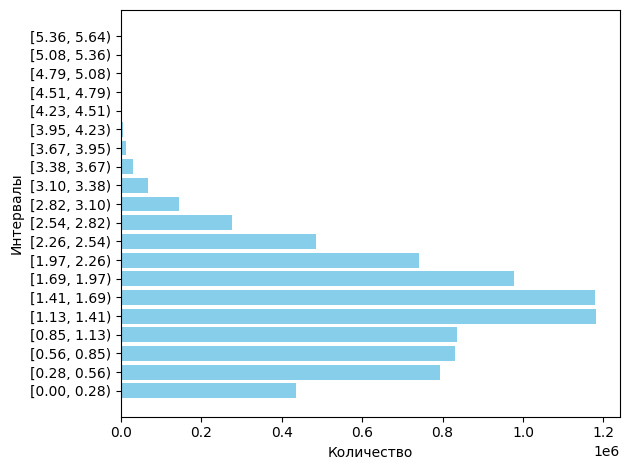

In [9]:
def build_distance_histogram(distance_matrix, bins=20):
    n = len(distance_matrix)
    distances = []
    for i in range(n):
        for j in range(i + 1, n):
            distances.append(distance_matrix[i][j])
    
    min_d, max_d = min(distances), max(distances)
    step = (max_d - min_d) / bins
    histogram = [0] * bins
    for d in distances:
        index = int((d - min_d) / step)
        if index == bins:
            index -= 1
        histogram[index] += 1
    
    binss = [f"[{min_d + i * step:.2f}, {min_d + (i + 1) * step:.2f})" for i in range(bins)]
    plt.barh(binss, histogram, color='skyblue')
    plt.xlabel('Количество')
    plt.ylabel('Интервалы')
    plt.tight_layout()
    plt.show()

build_distance_histogram(X_t)


9. Этап 7 — Кластеризация по Вроцлавской таксономии

Порог: 0.0810, Кластеры: 2, Внутрикластерный разброс: 1806.0822
Порог: 0.0759, Кластеры: 2, Внутрикластерный разброс: 1806.0822
Порог: 0.0709, Кластеры: 2, Внутрикластерный разброс: 1806.0822
Порог: 0.0658, Кластеры: 2, Внутрикластерный разброс: 1806.0822
Порог: 0.0607, Кластеры: 2, Внутрикластерный разброс: 1806.0822
Порог: 0.0556, Кластеры: 3, Внутрикластерный разброс: 1805.4686
Порог: 0.0506, Кластеры: 9, Внутрикластерный разброс: 1799.2507
Порог: 0.0455, Кластеры: 15, Внутрикластерный разброс: 1793.2046
Порог: 0.0404, Кластеры: 33, Внутрикластерный разброс: 1773.6727
Порог: 0.0354, Кластеры: 82, Внутрикластерный разброс: 1263.3805
Порог: 0.0303, Кластеры: 174, Внутрикластерный разброс: 1136.6482
Порог: 0.0252, Кластеры: 480, Внутрикластерный разброс: 626.4840
Порог: 0.0201, Кластеры: 923, Внутрикластерный разброс: 205.2012
Порог: 0.0151, Кластеры: 2117, Внутрикластерный разброс: 18.5319
Порог: 0.0100, Кластеры: 3022, Внутрикластерный разброс: 2.4189


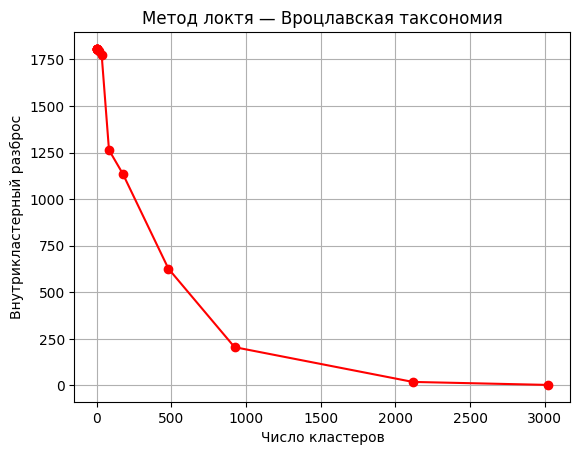

Порог: 0.5, Кластеры: 2


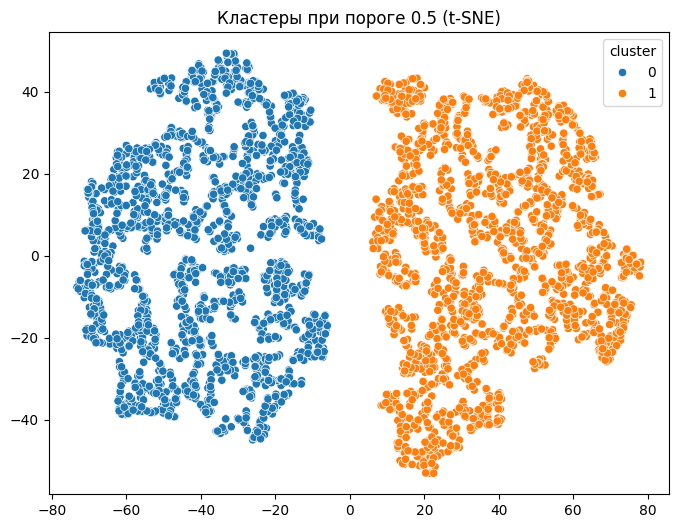

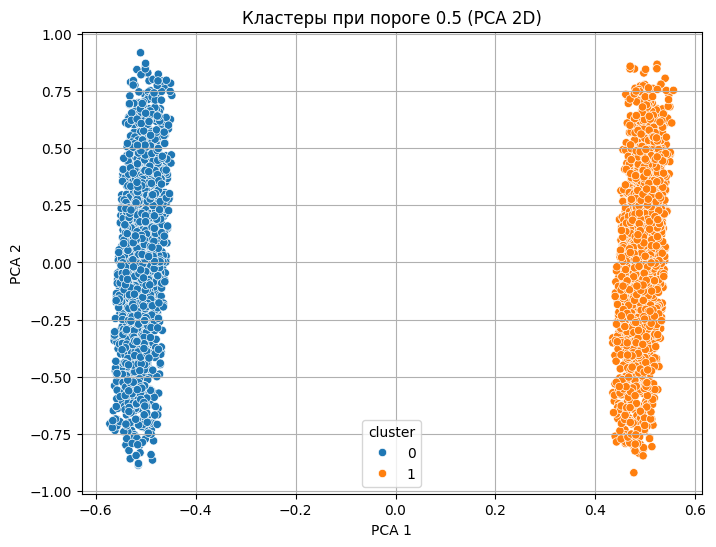

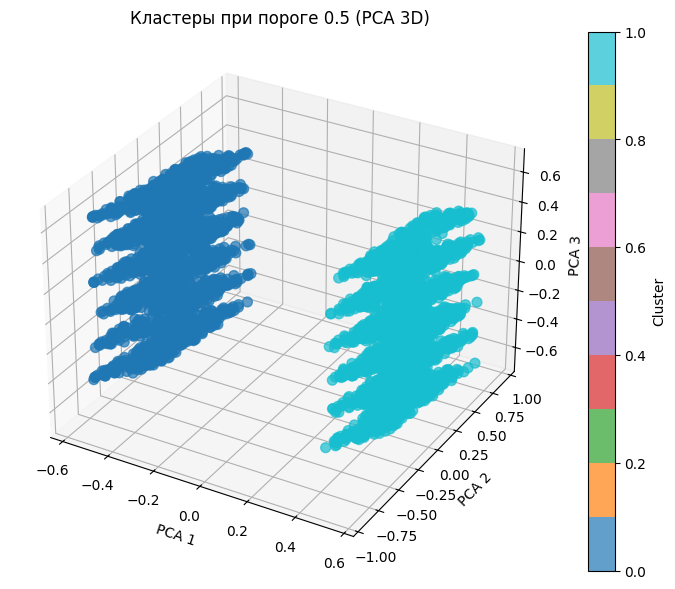

In [15]:
class WroclawTaxonomyClustering:
    def __init__(self, distance_matrix):
        self.distance_matrix = distance_matrix
        self.n = len(distance_matrix)
        self.graph = nx.Graph()
        self.graph.add_nodes_from(range(self.n))

    def cluster_with_threshold(self, threshold):
        self.graph.clear_edges()
        for i in range(self.n):
            for j in range(i + 1, self.n):
                if self.distance_matrix[i][j] < threshold:
                    self.graph.add_edge(i, j)
        components = list(nx.connected_components(self.graph))
        return [list(c) for c in components]

def compute_within_cluster_distance(distance_matrix, clusters):
    total = 0.0
    for cluster in clusters:
        if len(cluster) == 0:
            continue
        center = np.mean(X.iloc[cluster].values, axis=0)
        for i in cluster:
            v = X.iloc[i].values - center
            total += np.dot(v, v)
    return total

def wroclaw_taxonomy_elbow(distance_matrix, thresholds):
    scores = []
    cluster_counts = []
    for t in thresholds:
        clustering = WroclawTaxonomyClustering(distance_matrix)
        clusters = clustering.cluster_with_threshold(t)
        cluster_counts.append(len(clusters))
        score = compute_within_cluster_distance(distance_matrix, clusters)
        scores.append(score)
        print(f"Порог: {t:.4f}, Кластеры: {len(clusters)}, Внутрикластерный разброс: {score:.4f}")

    plt.plot(cluster_counts, scores, 'ro-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Внутрикластерный разброс')
    plt.title('Метод локтя — Вроцлавская таксономия')
    plt.grid(True)
    plt.show()
    return scores

thresholds = np.linspace(0.01, 0.081, num=15)[::-1]
wroclaw_taxonomy_elbow(X_t, thresholds)

# 1. Кластеризация с выбранным порогом
chosen_threshold = 0.5
clustering = WroclawTaxonomyClustering(X_t)
clusters = clustering.cluster_with_threshold(chosen_threshold)

# Присвоение меток кластеров
cluster_labels = np.full(X.shape[0], -1)
for idx, cluster in enumerate(clusters):
    for item in cluster:
        cluster_labels[item] = idx

X['cluster'] = cluster_labels

print(f"Порог: {chosen_threshold}, Кластеры: {len(clusters)}")

# 2. Визуализация t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(X.drop(columns=['cluster']))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=X['cluster'], palette='tab10', legend='full')
plt.title(f'Кластеры при пороге {chosen_threshold} (t-SNE)')
plt.show()

# 3. Визуализация PCA 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X.drop(columns=['cluster']))

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=X['cluster'], palette='tab10', legend='full')
plt.title(f'Кластеры при пороге {chosen_threshold} (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

# 4. Визуализация PCA 3D
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(X.drop(columns=['cluster']))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    pca_result_3d[:, 0], pca_result_3d[:, 1], pca_result_3d[:, 2],
    c=X['cluster'], cmap='tab10', s=50, alpha=0.7
)

ax.set_title(f'Кластеры при пороге {chosen_threshold} (PCA 3D)')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


8 этап — Индекс силуэта для кластеризации Вроцлавской таксономии

=== Вроцлавская таксономия: Р М СК НЗ с индексом силуэта ===
Порог: 0.0810, Кластеры: 2, Внутрикластерный разброс: 1806.0822, Silhouette: 0.34003623984338854
Порог: 0.0759, Кластеры: 2, Внутрикластерный разброс: 1806.0822, Silhouette: 0.34003623984338854
Порог: 0.0709, Кластеры: 2, Внутрикластерный разброс: 1806.0822, Silhouette: 0.34003623984338854
Порог: 0.0658, Кластеры: 2, Внутрикластерный разброс: 1806.0822, Silhouette: 0.34003623984338854
Порог: 0.0607, Кластеры: 2, Внутрикластерный разброс: 1806.0822, Silhouette: 0.34003623984338854
Порог: 0.0556, Кластеры: 3, Внутрикластерный разброс: 1805.4686, Silhouette: 0.1844333532910923
Порог: 0.0506, Кластеры: 9, Внутрикластерный разброс: 1799.2507, Silhouette: -0.16058454862108776
Порог: 0.0455, Кластеры: 15, Внутрикластерный разброс: 1793.2046, Silhouette: -0.29302035562122264
Порог: 0.0404, Кластеры: 33, Внутрикластерный разброс: 1773.6727, Silhouette: -0.4304400464171466
Порог: 0.0354, Кластеры: 82, Внутрикластерный разброс: 1263.380

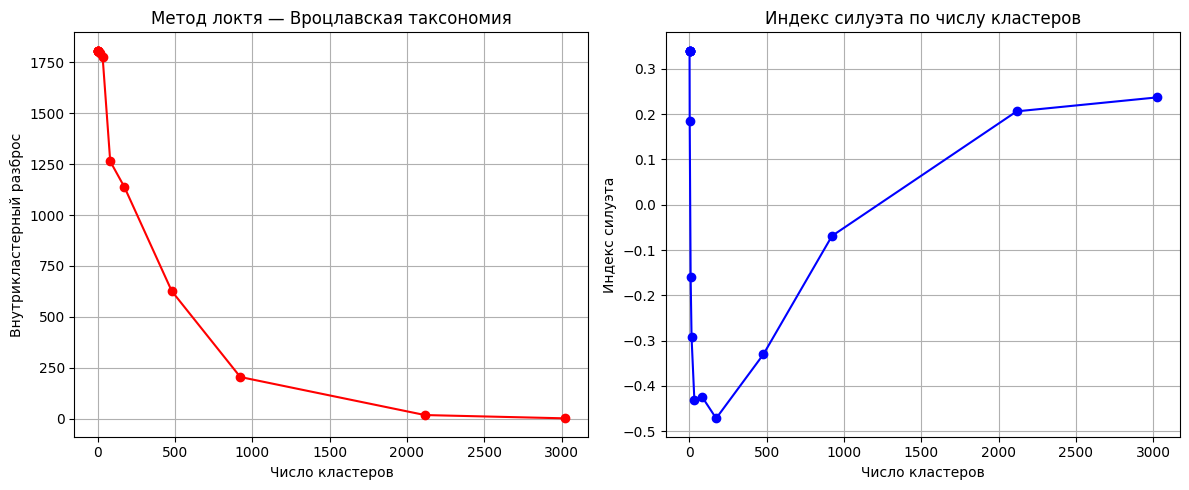

([np.float64(1806.0822382296665),
  np.float64(1806.0822382296665),
  np.float64(1806.0822382296665),
  np.float64(1806.0822382296665),
  np.float64(1806.0822382296665),
  np.float64(1805.468551772782),
  np.float64(1799.2506634647063),
  np.float64(1793.2046144311541),
  np.float64(1773.6727204551614),
  np.float64(1263.3804874284658),
  np.float64(1136.6481754097967),
  np.float64(626.4840302015398),
  np.float64(205.20117823007647),
  np.float64(18.531880453923264),
  np.float64(2.4188550780663576)],
 [np.float64(0.34003623984338854),
  np.float64(0.34003623984338854),
  np.float64(0.34003623984338854),
  np.float64(0.34003623984338854),
  np.float64(0.34003623984338854),
  np.float64(0.1844333532910923),
  np.float64(-0.16058454862108776),
  np.float64(-0.29302035562122264),
  np.float64(-0.4304400464171466),
  np.float64(-0.42358725106827905),
  np.float64(-0.47158207455687184),
  np.float64(-0.3300156415327573),
  np.float64(-0.06883818725675397),
  np.float64(0.20615170624600473

In [10]:
from sklearn.metrics import silhouette_score

def wroclaw_taxonomy_elbow_with_silhouette(distance_matrix, thresholds):
    print("=== Вроцлавская таксономия: Р М СК НЗ с индексом силуэта ===")
    scores = []
    silhouettes = []
    cluster_counts = []

    for t in thresholds:
        clustering = WroclawTaxonomyClustering(distance_matrix)
        clusters = clustering.cluster_with_threshold(t)
        cluster_counts.append(len(clusters))
        score = compute_within_cluster_distance(distance_matrix, clusters)

        labels = np.zeros(len(distance_matrix), dtype=int)
        for cluster_id, cluster in enumerate(clusters):
            for index in cluster:
                labels[index] = cluster_id

        n_clusters = len(set(labels))
        if n_clusters > 1:
            silhouette = silhouette_score(X.values, labels, metric='euclidean')
        else:
            silhouette = np.nan

        scores.append(score)
        silhouettes.append(silhouette)

        print(f"Порог: {t:.4f}, Кластеры: {len(clusters)}, Внутрикластерный разброс: {score:.4f}, Silhouette: {silhouette}")

    filtered_counts = [c for c, s in zip(cluster_counts, silhouettes) if not np.isnan(s)]
    filtered_silhouettes = [s for s in silhouettes if not np.isnan(s)]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(cluster_counts, scores, 'ro-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Внутрикластерный разброс')
    plt.title('Метод локтя — Вроцлавская таксономия')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(filtered_counts, filtered_silhouettes, 'bo-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Индекс силуэта')
    plt.title('Индекс силуэта по числу кластеров')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return scores, silhouettes

# %%
thresholds = np.linspace(0.01, 0.081, num=15)
wroclaw_taxonomy_elbow_with_silhouette(X_t, thresholds[::-1])

 Индекс Калински-Харабаша для кластеров Вроцлавской таксономии

=== Вроцлавская таксономия с индексом Калински-Харабаша ===
Порог: 0.0810, Кластеры: 2, Индекс Калински-Харабаша: 2216.656138043171
Порог: 0.0759, Кластеры: 2, Индекс Калински-Харабаша: 2216.656138043171
Порог: 0.0709, Кластеры: 2, Индекс Калински-Харабаша: 2216.656138043171
Порог: 0.0658, Кластеры: 2, Индекс Калински-Харабаша: 2216.656138043171
Порог: 0.0607, Кластеры: 2, Индекс Калински-Харабаша: 2216.656138043171
Порог: 0.0556, Кластеры: 3, Индекс Калински-Харабаша: 1109.1067782696193
Порог: 0.0506, Кластеры: 9, Индекс Калински-Харабаша: 279.5412703086007
Порог: 0.0455, Кластеры: 15, Индекс Калински-Харабаша: 160.99520589137683
Порог: 0.0404, Кластеры: 33, Индекс Калински-Харабаша: 72.25454820568406
Порог: 0.0354, Кластеры: 82, Индекс Калински-Харабаша: 59.116912172513764
Порог: 0.0303, Кластеры: 174, Индекс Калински-Харабаша: 32.50853639960742
Порог: 0.0252, Кластеры: 480, Индекс Калински-Харабаша: 25.58266499753219
Порог: 0.0201, Кластеры: 923, Индекс Калински-Харабаша: 42.3219174

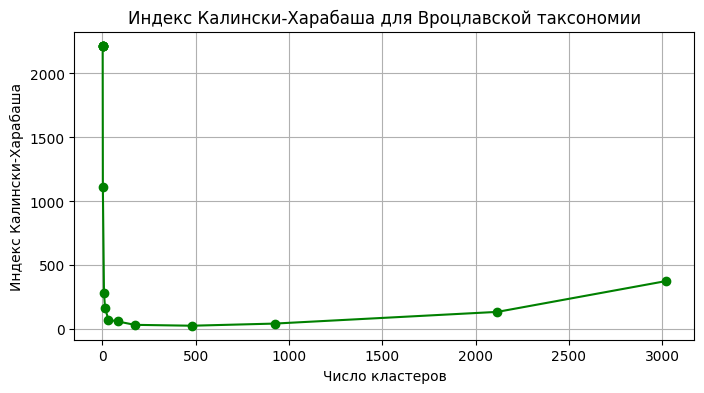

[np.float64(2216.656138043171),
 np.float64(2216.656138043171),
 np.float64(2216.656138043171),
 np.float64(2216.656138043171),
 np.float64(2216.656138043171),
 np.float64(1109.1067782696193),
 np.float64(279.5412703086007),
 np.float64(160.99520589137683),
 np.float64(72.25454820568406),
 np.float64(59.116912172513764),
 np.float64(32.50853639960742),
 np.float64(25.58266499753219),
 np.float64(42.32191743521683),
 np.float64(133.92163245546496),
 np.float64(375.41858915387724)]

In [11]:
from sklearn.metrics import calinski_harabasz_score

def wroclaw_taxonomy_with_calinski(distance_matrix, thresholds):
    print("=== Вроцлавская таксономия с индексом Калински-Харабаша ===")
    ch_scores = []
    cluster_counts = []

    for t in thresholds:
        clustering = WroclawTaxonomyClustering(distance_matrix)
        clusters = clustering.cluster_with_threshold(t)
        cluster_counts.append(len(clusters))

        labels = np.zeros(len(distance_matrix), dtype=int)
        for cluster_id, cluster in enumerate(clusters):
            for index in cluster:
                labels[index] = cluster_id

        if len(set(labels)) > 1:
            ch_score = calinski_harabasz_score(X.values, labels)
        else:
            ch_score = np.nan

        ch_scores.append(ch_score)
        print(f"Порог: {t:.4f}, Кластеры: {len(clusters)}, Индекс Калински-Харабаша: {ch_score}")

    filtered_counts = [c for c, s in zip(cluster_counts, ch_scores) if not np.isnan(s)]
    filtered_scores = [s for s in ch_scores if not np.isnan(s)]

    plt.figure(figsize=(8,4))
    plt.plot(filtered_counts, filtered_scores, 'go-')
    plt.xlabel('Число кластеров')
    plt.ylabel('Индекс Калински-Харабаша')
    plt.title('Индекс Калински-Харабаша для Вроцлавской таксономии')
    plt.grid(True)
    plt.show()

    return ch_scores

# %%
thresholds = np.linspace(0.01, 0.081, num=15)
wroclaw_taxonomy_with_calinski(X_t, thresholds[::-1])